# Calidad de un Vino

Diego Pérez Tapia<br>
ROL: 201173045-3

### a)

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
np.random.seed(42)

df_red = pd.read_csv("winequality-red.csv",sep=";")
df_red["type"] = pd.Series(np.zeros(len(df_red.index)))
df_white = pd.read_csv("winequality-white.csv",sep=";")
df_white["type"] = pd.Series(np.ones(len(df_white.index)))
df = pd.concat([df_red,df_white], axis=0, ignore_index=True)

In [2]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.753886
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


### b)

In [3]:
df["good_quality"] = [1 if q>5 else 0 for q in df.quality]
df = df.drop("quality", axis=1)

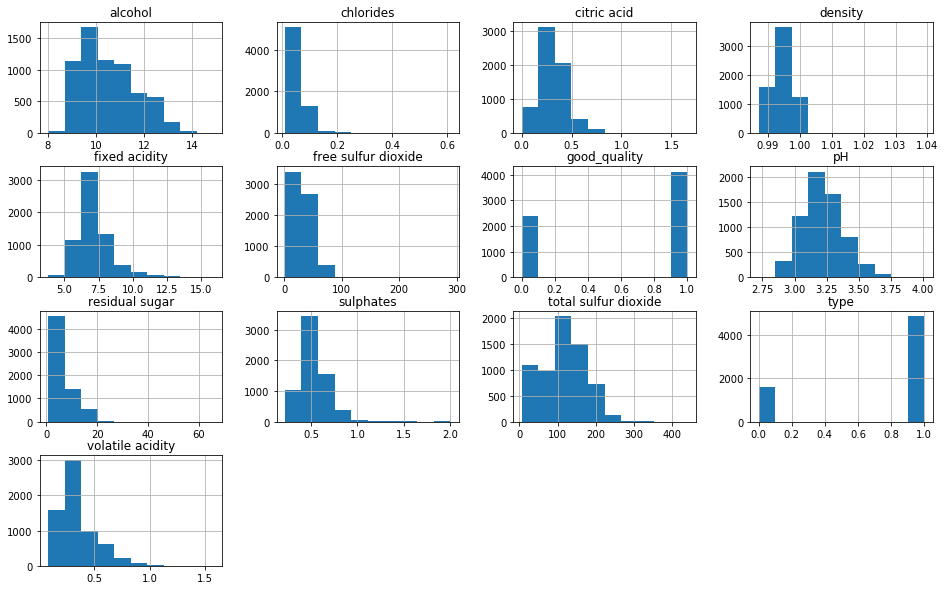

In [4]:
h = df.hist(figsize=(16,10))

In [5]:
from sklearn.model_selection import train_test_split

x_tr, x_te, y_tr, y_te = train_test_split(df[df.columns[:df.columns.size-1]], df[df.columns[-1]], test_size=0.25)
print(x_tr.shape, y_tr.shape, x_te.shape, y_te.shape)

(4872, 12) (4872,) (1625, 12) (1625,)


### c)

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [96]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

splitters = ["best", "random"]
criterions = ["gini", "entropy"]
max_depths = [None,5,15,20,30,40]

param_grid = dict(  criterion=criterions,
                    splitter=splitters,
                    max_depth=max_depths)

grid = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, scoring="f1")
results = grid.fit(x_tr, y_tr)

In [97]:
results.best_params_

{'criterion': 'entropy', 'max_depth': 15, 'splitter': 'best'}

In [98]:
results.best_score_

0.80884975031780804

Confusion matrix, without normalization
[[398 186]
 [200 841]]


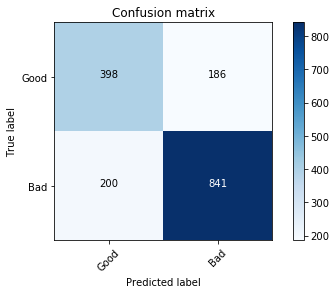

In [99]:
classes = ["Good", "Bad"]
plot_confusion_matrix(confusion_matrix(y_te, grid.predict(x_te)), classes)

### d)

In [48]:
from sklearn.ensemble import RandomForestClassifier

scores = []
best_score = 0
best_clf = None
for n in range(1,20):
    model = RandomForestClassifier(n_estimators=n, max_depth=5, n_jobs=-1)
    model.fit(x_tr, y_tr)
    y_hat_tr = model.predict(x_tr)
    y_hat_te = model.predict(x_te)
    s_tr = f1_score(y_tr, y_hat_tr)
    s_te= f1_score(y_te, y_hat_te)
    scores.append([s_tr, s_te])
    if s_te > best_score:
        best_clf = model
scores = np.array(scores)

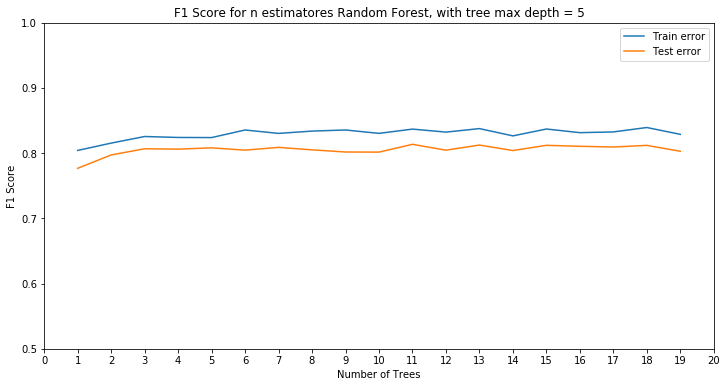

Test max F1 score =  0.813450023031
Confusion matrix, without normalization
[[341 243]
 [180 861]]


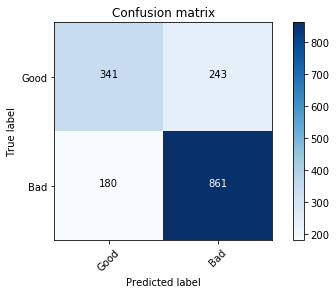

In [49]:
f, ax = plt.subplots(1)
f.set_size_inches(12,6)
ax.plot(np.arange(1,20), scores[:,0], label="Train error")
ax.plot(np.arange(1,20), scores[:,1], label="Test error")
ax.set_ylim([0.5,1])
ax.set_xticks(np.arange(0,21))
ax.set_ylabel("F1 Score")
ax.set_xlabel("Number of Trees")
ax.set_title("F1 Score for n estimatores Random Forest, with tree max depth = 5")
ax.legend()
plt.show()
print("Test max F1 score = ", scores[:,1].max())
plot_confusion_matrix(confusion_matrix(y_te, best_clf.predict(x_te)), classes)

In [46]:
scores = []
best_score = 0
best_clf = None
for n in range(1,20):
    model = RandomForestClassifier(n_estimators=n, max_depth=15, n_jobs=-1)
    model.fit(x_tr, y_tr)
    y_hat_tr = model.predict(x_tr)
    y_hat_te = model.predict(x_te)
    s_tr = f1_score(y_tr, y_hat_tr)
    s_te= f1_score(y_te, y_hat_te)
    scores.append([s_tr, s_te])
    if s_te > best_score:
        best_clf = model
scores = np.array(scores)

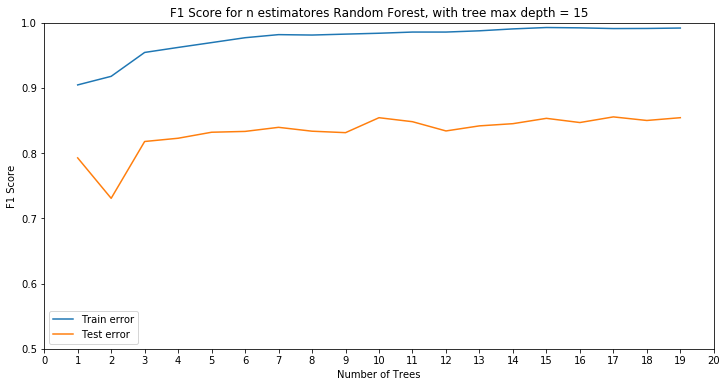

Test max F1 score =  0.855507868383
Confusion matrix, without normalization
[[426 158]
 [147 894]]


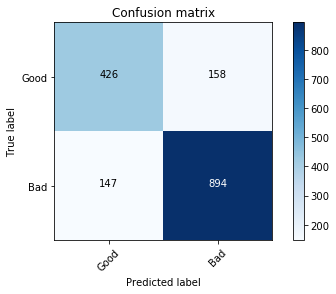

In [47]:
f, ax = plt.subplots(1)
f.set_size_inches(12,6)
ax.plot(np.arange(1,20), scores[:,0], label="Train error")
ax.plot(np.arange(1,20), scores[:,1], label="Test error")
ax.set_ylim([0.5,1])
ax.set_xticks(np.arange(0,21))
ax.set_ylabel("F1 Score")
ax.set_xlabel("Number of Trees")
ax.set_title("F1 Score for n estimatores Random Forest, with tree max depth = 15")
ax.legend()
plt.show()
print("Test max F1 score = ", scores[:,1].max())
plot_confusion_matrix(confusion_matrix(y_te, best_clf.predict(x_te)), classes)

### e)

In [44]:
from sklearn.ensemble import AdaBoostClassifier

scores = []
best_score = 0
best_clf = None
for n in range(1,20):
    tree = DecisionTreeClassifier(max_depth=5)
    model = AdaBoostClassifier(base_estimator=tree, n_estimators=n)
    model.fit(x_tr, y_tr)
    y_hat_tr = model.predict(x_tr)
    y_hat_te = model.predict(x_te)
    s_tr = f1_score(y_tr, y_hat_tr)
    s_te= f1_score(y_te, y_hat_te)
    scores.append([s_tr, s_te])
    if s_te > best_score:
        best_clf = model
scores = np.array(scores)

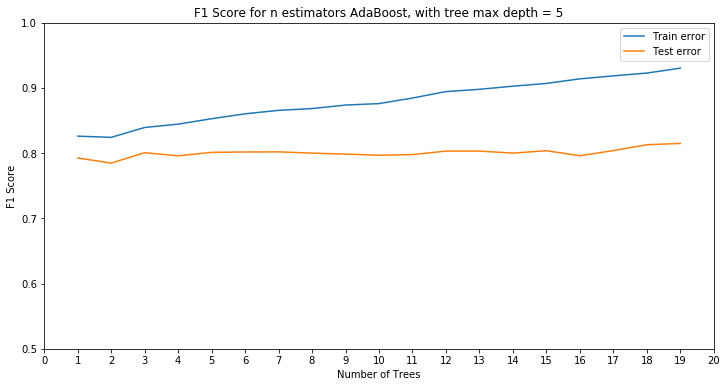

Test max F1 score =  0.814850071395
Confusion matrix, without normalization
[[380 204]
 [185 856]]


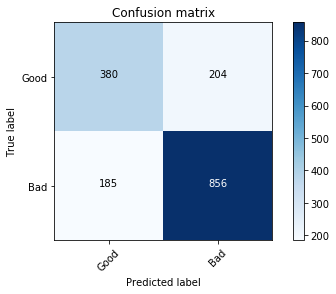

In [45]:
f, ax = plt.subplots(1)
f.set_size_inches(12,6)
ax.plot(np.arange(1,20), scores[:,0], label="Train error")
ax.plot(np.arange(1,20), scores[:,1], label="Test error")
ax.set_ylim([0.5,1])
ax.set_xticks(np.arange(0,21))
ax.set_ylabel("F1 Score")
ax.set_xlabel("Number of Trees")
ax.set_title("F1 Score for n estimators AdaBoost, with tree max depth = 5")
ax.legend()
plt.show()
print("Test max F1 score = ", scores[:,1].max())
plot_confusion_matrix(confusion_matrix(y_te, best_clf.predict(x_te)), classes)

In [42]:
from sklearn.ensemble import AdaBoostClassifier

scores = []
best_score = 0
best_clf = None
for n in range(1,20):
    tree = DecisionTreeClassifier(max_depth=15)
    model = AdaBoostClassifier(base_estimator=tree, n_estimators=n)
    model.fit(x_tr, y_tr)
    y_hat_tr = model.predict(x_tr)
    y_hat_te = model.predict(x_te)
    s_tr = f1_score(y_tr, y_hat_tr)
    s_te= f1_score(y_te, y_hat_te)
    scores.append([s_tr, s_te])
    if s_te > best_score:
        best_clf = model
scores = np.array(scores)

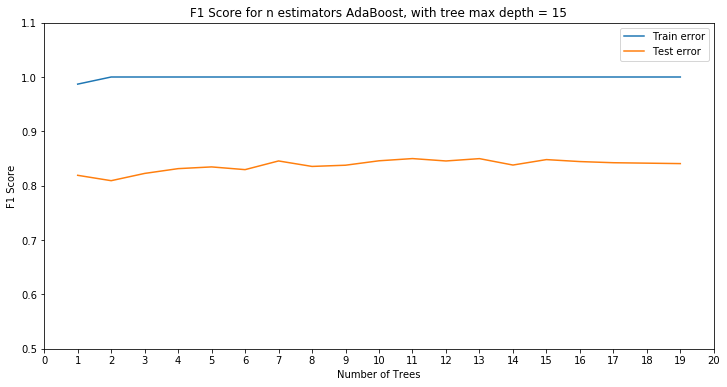

Test max F1 score =  0.849928537399
Confusion matrix, without normalization
[[417 167]
 [165 876]]


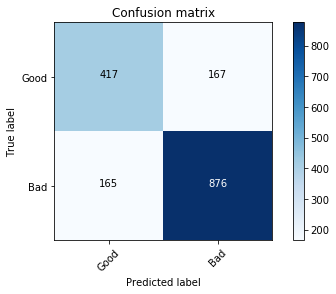

In [43]:
f, ax = plt.subplots(1)
f.set_size_inches(12,6)
ax.plot(np.arange(1,20), scores[:,0], label="Train error")
ax.plot(np.arange(1,20), scores[:,1], label="Test error")
ax.set_ylim([0.5,1.1])
ax.set_xticks(np.arange(0,21))
ax.set_ylabel("F1 Score")
ax.set_xlabel("Number of Trees")
ax.set_title("F1 Score for n estimators AdaBoost, with tree max depth = 15")
ax.legend()
plt.show()
print("Test max F1 score = ", scores[:,1].max())
plot_confusion_matrix(confusion_matrix(y_te, best_clf.predict(x_te)), classes)

### f) 

Training Set - F1 score =  0.820846905537
Test Set - F1 score =  0.807656395892
Confusion matrix, without normalization
[[348 236]
 [176 865]]


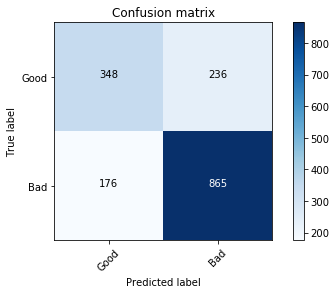

In [54]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(x_tr)
x_tr_s = scaler.transform(x_tr)
x_te_s = scaler.transform(x_te)

clf = SVC(C=1, kernel="rbf", gamma=0.99)
clf.fit(x_tr_s, y_tr)
print("Training Set - F1 score = ", f1_score(y_tr, clf.predict(x_tr_s)))
print("Test Set - F1 score = ", f1_score(y_te, clf.predict(x_te_s)))
plot_confusion_matrix(confusion_matrix(y_te, clf.predict(x_te_s)), classes)

In [56]:
scores = []
best_score = 0
best_clf = None
for n in range(1,20):
    cfl = clf = SVC(C=1, kernel="rbf", probability=True)
    model = AdaBoostClassifier(base_estimator=cfl, n_estimators=n)
    model.fit(x_tr, y_tr)
    y_hat_tr = model.predict(x_tr)
    y_hat_te = model.predict(x_te)
    s_tr = f1_score(y_tr, y_hat_tr)
    s_te= f1_score(y_te, y_hat_te)
    scores.append([s_tr, s_te])
    if s_te > best_score:
        best_clf = model
scores = np.array(scores)

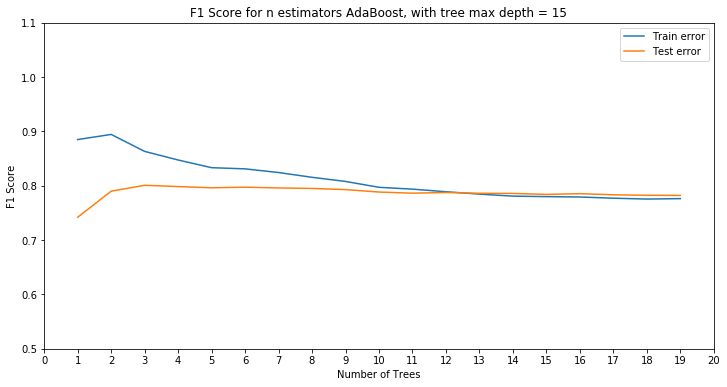

Test max F1 score =  0.800823045267
Confusion matrix, without normalization
[[   4  580]
 [   0 1041]]


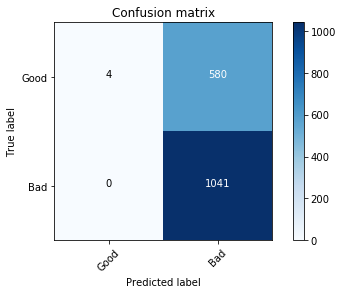

In [57]:
f, ax = plt.subplots(1)
f.set_size_inches(12,6)
ax.plot(np.arange(1,20), scores[:,0], label="Train error")
ax.plot(np.arange(1,20), scores[:,1], label="Test error")
ax.set_ylim([0.5,1.1])
ax.set_xticks(np.arange(0,21))
ax.set_ylabel("F1 Score")
ax.set_xlabel("Number of Trees")
ax.set_title("F1 Score for n estimators AdaBoost, with SVM kernel=rbf and C=1)
ax.legend()
plt.show()
print("Test max F1 score = ", scores[:,1].max())
plot_confusion_matrix(confusion_matrix(y_te, best_clf.predict(x_te)), classes)

### g)